# Credcastle - System Modelling & Simulation

In [1]:
import json
import random # psuedo randomness generator
import numpy as np # import numerical python
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from cadCAD.configuration import Configuration

#imported some addition utilities to help with configuration set-up
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import append_configs
from cadCAD import configs

In [2]:
# What does this do?
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})


## Differential Specification

<img src="images/credcastle_diffspec.jpg" />

## Initial conditions

In [3]:
total_villagers = 10

In [4]:
# Params

initial_conditions = {
    'village_folk': {i:{'stuff': np.random.randint(1,10), 'tokens':0} for i in range(total_villagers)}, # initialize village folk and their stuff and cred_castle balances
    'castle': 0, # the cred castle
    'castle_token_supply': 0, # the amount of castle tokens
}

## Policies

In [5]:
# Everyone in CredLand is crazy 
def villagers_be_crazy(_params, substep, sH, s):
    """
    
        A User behaviour Policy that executes a strategy based on information 
        gathered from available state variables, metrics, external factors, 
        internal beliefs, and utility functions
        
        Policy Functions are most commonly used as representations of the behavior of agents 
        that interact with the components of the system we're simulating
        
        Signals are
        
        Parameters
        ----------
        param _params : dict
            System parameters
        substep : int
            Current substep
        sH : list[list[dict]]
            Historical values of all state variables for the simulation. 
            See Historical State Access for details
        s : dict
            Current state of the system, where the dict_keys are the names of the state 
            variables and the dict_values are their current values.
        _input : dict
            Aggregation of the signals of all policy functions in the current 
            Partial State Update Block
            
        Returns
        -------
        dict
            signals to be sent to the subsequent PSUBs
            PSUBs -> Partial State Update Blocks
    """
    n = len(s['village_folk']) #get the length of the list of villager indices
    #print('go crazy')
    index = np.random.randint(0, n) #pick a random integer from (0,.., n-1)
    p = np.random.randint(0, 100)
    print('Probs', p)
    if p <= 50:
        #print("if 1")
        action = 'buy_castle_token'
        #i need to buy FROM someone
        #select the set of village_folk who have tokens
        holders = [i for i in range(n) if s['village_folk'][i]['tokens'] > 0]
        if len(holders) > 0:
            friend = np.random.choice(holders)
        else:
            action = None
            friend = None
        

    #you cannot sell tokens you don't have
    elif (p > 80) & (s['village_folk'][index]['tokens'] > 0):
        #print("if 2")
        action = 'sell_castle_token'
        #i need to sell TO someone
        #select the set of village_folk who have stuff
        stuff_havers = [i for i in range(n) if s['village_folk'][i]['stuff'] > 0]
        friend = np.random.choice(stuff_havers)
    
    elif (p > 50):
        #print("if 3")
        action = 'build'
        friend = None
    
    #print("Carry out %s for villager %s" % (action, index))
    #print(s['village_folk'][index])
    return ({'action': action, 'villager': index, 'friend': friend})

#    return (x, y)

## Partial State Update mechanisms

In [6]:
# How villagers build the castle 
def build_castle(_params, substep, sH, s, _input):
    """
        Parameters
        ----------
        param _params : dict
            System parameters
        substep : int
            Current substep
        sH : list[list[dict]]
            Historical values of all state variables for the simulation. 
            See Historical State Access for details
        s : dict
            Current state of the system, where the dict_keys are the names of the state 
            variables and the dict_values are their current values.
        _input : dict
            Aggregation of the signals of all policy functions in the current 
            Partial State Update Block
            
        Returns
        -------
        tuple
            name and updated value for a state variable
    """
    y = 'castle' #this function updates the castle state
    x = s[y]
    if _input['action'] == 'build':
        x += 1
    #print(y)
    #print(x)
    return (y, x)

In [7]:
# Castle token supply
def account_castle_tokens(_params, substep, sH, s, _input):
    y = 'castle_token_supply' #this function updates the castle state
    x = s[y]
    if _input['action'] == 'build':
        x += 1
    return (y, x)

In [10]:
# How villagers buy/sell/gain castle tokens 
def castle_tokens_market(params, step, sH, s, _input):
    print('castle_tokens_market')
    action = _input['action']
    #print('buy_castle_token')
    y = 'village_folk'
    x = s[y]
    
    if _input['action'] in ['buy_castle_token', 'sell_castle_token']: #  Buy/Sell
        print('Buy/Sell')
        buyer = _input['villager'] if action == 'buy_castle_token' else _input['friend']
        seller = _input['friend'] if action == 'buy_castle_token' else _input['villager']
        
        #token accounting
        x[buyer]['tokens'] += 1 
        x[seller]['tokens'] -= 1
        #stuff accounting
        x[buyer]['stuff'] -= 1 
        x[seller]['stuff'] += 1
    
    elif _input['action'] == 'build': #  Build
        print('build')
        villager_index = _input['villager']
        x[villager_index]['tokens'] += 1

    return(y, x)

## Setting Partial State Update Blocks

In [11]:
# Everyone in CredLand is crazy 
partial_state_update_blocks = [
    { 
        'policies': {
            'villagers': villagers_be_crazy
        },
        'variables': {
            'castle': build_castle,
            'castle_token_supply': account_castle_tokens,
            'village_folk': castle_tokens_market,
 #           'buy_castle_tokens': buy_castle_tokens,
 #           'sell_castle_tokens': sell_castle_tokens
        }
    }
]

In [12]:
len(partial_state_update_blocks)

1

## Running a cadCAD simulation

In [13]:
simulation_parameters = {
    'T': range(50),
    'N': 1,
    'M': {}
}

In [15]:
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

In [16]:
# What does this do and why doesn't it work?
# this provides instructions to your computer on how to run your model
# since nothing actually gets executed until this cell, errors the model above
# trigger errors when you run this cell
from cadCAD.engine import ExecutionMode, ExecutionContext
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

In [17]:
from cadCAD.engine import Executor
from cadCAD import configs
simulation = Executor(exec_context=local_mode_ctx, configs=configs)

In [18]:
import pandas as pd
raw_system_events, tensor_field, sessions = simulation.execute()

# Simulation Result Types:
# raw_system_events: List[dict] 
# tensor_field: pd.DataFrame

# Result System Events DataFrame
sim_df = pd.DataFrame(raw_system_events)

Configurations Length: 1
Execution Method: local_simulations
Execution Mode: single_threaded
Probs 63
castle_tokens_market
build
Probs 39
castle_tokens_market
Buy/Sell
Probs 28
castle_tokens_market
Buy/Sell
Probs 84
castle_tokens_market
build
Probs 64
castle_tokens_market
build
Probs 38
castle_tokens_market
Buy/Sell
Probs 20
castle_tokens_market
Buy/Sell
Probs 59
castle_tokens_market
build
Probs 90
castle_tokens_market
build
Probs 4
castle_tokens_market
Buy/Sell
Probs 10
castle_tokens_market
Buy/Sell
Probs 44
castle_tokens_market
Buy/Sell
Probs 74
castle_tokens_market
build
Probs 66
castle_tokens_market
build
Probs 25
castle_tokens_market
Buy/Sell
Probs 72
castle_tokens_market
build
Probs 30
castle_tokens_market
Buy/Sell
Probs 53
castle_tokens_market
build
Probs 3
castle_tokens_market
Buy/Sell
Probs 84
castle_tokens_market
Buy/Sell
Probs 21
castle_tokens_market
Buy/Sell
Probs 50
castle_tokens_market
Buy/Sell
Probs 14
castle_tokens_market
Buy/Sell
Probs 1
castle_tokens_market
Buy/Sell
P

## Analyzing Results

In [19]:
sim_df.set_index(['run', 'substep', 'simulation'], inplace=True)

In [20]:
def json_to_series(dct):
    keys, values = zip(*[(k, v) for k, v in dct.items()])
    return pd.Series(values, index=keys)

data = pd.concat([sim_df, sim_df['village_folk'].apply(json_to_series)], axis=1)
data

village_folk  \
run substep simulation                                                      
1   0       0           {0: {'stuff': 2, 'tokens': 0}, 1: {'stuff': 1,...   
            0           {0: {'stuff': 2, 'tokens': 0}, 1: {'stuff': 1,...   
            0           {0: {'stuff': 2, 'tokens': 0}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 2, 'tokens': 0}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 3, 'tokens': 0}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 3, 'tokens': 0}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 3, 'tokens': 0}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 3, 'tokens': 0}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 3, 'tokens': 0}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 3, 'tokens': 0}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 3, 'tokens': 0}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 3, 'tokens': 0}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 3, 'tokens': 0}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 3, 'tokens': 0}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 3, 'tokens': 0}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 3, 'tokens': 0}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 3, 'tokens': 0}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 3, 'tokens': 0}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 3, 'tokens': 0}, 1: {'stuff': 1,...   
            0           {0: {'stuff': 3, 'tokens': 0}, 1: {'stuff': 1,...   
            0           {0: {'stuff': 3, 'tokens': 0}, 1: {'stuff': 1,...   
            0           {0: {'stuff': 3, 'tokens': 0}, 1: {'stuff': 1,...   
            0           {0: {'stuff': 3, 'tokens': 0}, 1: {'stuff': 1,...   
            0           {0: {'stuff': 3, 'tokens': 0}, 1: {'stuff': 1,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 1,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 1,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 1,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 2,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 3,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 3,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 3,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 3,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 3,...   
            0           {0: {'stuff': 2, 'tokens': 1}, 1: {'stuff': 3,...   
            0           {0: {'stuff': 3, 'tokens': 0}, 1: {'stuff': 3,...   
            0           {0: {'stuff': 3, 'tokens': 0}, 1: {'stuff': 3,...   
    1       0           {0: {'stuff': 3, 'tokens': 0}, 1:

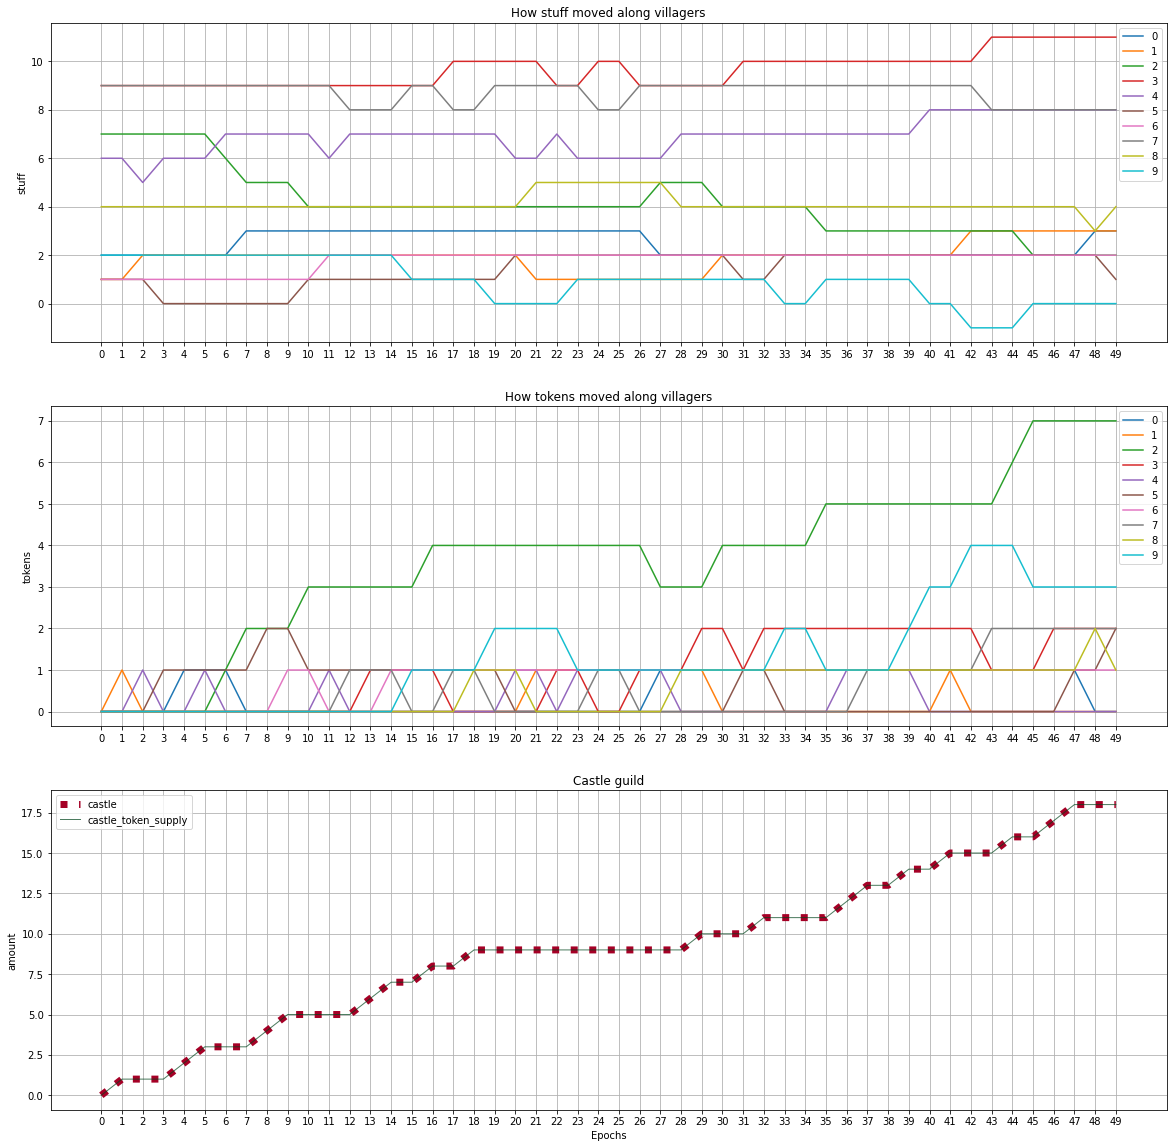

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 20));

ax1 = axes[0]
for i in range(total_villagers):
    data[i].apply(lambda x: x['stuff'])[:-1].plot(use_index=False,# figsize=(15, 10), 
                                                       legend=True, grid=True,
                                                       xticks=list(simulation_parameters['T']),
                                                       ax=ax1,
                                                       title='How stuff moved along villagers'
                                                      )
ax1.set_ylabel('stuff');

ax2 = axes[1]
for i in range(total_villagers):
    data[i].apply(lambda x: x['tokens'])[:-1].plot(use_index=False,# figsize=(15, 10), 
                                                       legend=True, grid=True,
                                                       xticks=list(simulation_parameters['T']),
                                                       ax=ax2,
                                                       title='How tokens moved along villagers'
                                                      )
# ax.set_xlabel('epochs')
ax2.set_ylabel('tokens');


ax3 = axes[2]
data[:-1].plot('timestep', ['castle'], 
               use_index=False,# figsize=(15, 10),
               legend=True,
               xticks=list(simulation_parameters['T']),
               title='Castle guild',
               style=':', colormap='RdYlGn',
               lw=7,
               ax=ax3
              )
data[:-1].plot('timestep', ['castle_token_supply'], 
               use_index=False, #figsize=(15, 10),
               legend=True,
#                xticks=list(simulation_parameters['T']),
               title='Castle guild',
               style='-', colormap = 'BuGn_r', alpha=0.7,
               lw=1,
               ax=ax3,
               grid=True, 
               xticks=list(simulation_parameters['T'])
              )
ax3.set_ylabel('amount');
ax3.set_xlabel('Epochs');
